In [2]:
!pip install keras cython h5py --quiet

In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import keras

Using TensorFlow backend.


In [3]:
with zipfile.ZipFile('data/training.zip') as zip:
    with zip.open('training.csv') as myZip:
        train_df = pd.read_csv(myZip)

In [4]:
train_df.shape

(7049, 31)

In [5]:
train_df.drop('Image', axis=1).head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774


In [6]:
train_df['Image'][0][:50]

'238 236 237 238 240 240 239 241 241 243 240 239 23'

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

In [8]:
four_keypoints = train_df.loc[:, ['nose_tip_x', 'nose_tip_y',
                                  'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y',
                                  'left_eye_center_x', 'left_eye_center_y',
                                  'right_eye_center_x', 'right_eye_center_y',
                                  'Image']
                             ].dropna().reset_index(drop=True)

four_keypoints.shape

(7000, 9)

In [9]:
X = four_keypoints['Image'].apply(lambda image: np.fromstring(image, sep=' '))
y = four_keypoints.drop('Image', axis=1).values

In [10]:
X = np.vstack(X) / 255
y = (y - 48) / 48

In [11]:
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, Activation, Dense, Flatten
from keras.models import Sequential

In [12]:
cnn = Sequential([
    Conv2D(16, kernel_size=(3, 3),
           activation='relu',
           input_shape=(96,96,1)),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(.2),
    
    Conv2D(32, kernel_size=(2, 2),
           activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(.3),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(.5),
    
    Dense(8)
])

In [13]:
cnn.compile(loss='mse', optimizer='sgd')

In [14]:
X2 = X.reshape(-1, 96, 96, 1)

In [13]:
cnn.fit(X2, y, validation_split=.2, epochs=100)

Train on 5600 samples, validate on 1400 samples
Epoch 1/100
5600/5600 [==============================] - 4s - loss: 0.0426 - val_loss: 0.0231
Epoch 2/100
5600/5600 [==============================] - 3s - loss: 0.0268 - val_loss: 0.0179
Epoch 3/100
5600/5600 [==============================] - 3s - loss: 0.0209 - val_loss: 0.0151
Epoch 4/100
5600/5600 [==============================] - 3s - loss: 0.0175 - val_loss: 0.0116
Epoch 5/100
5600/5600 [==============================] - 3s - loss: 0.0155 - val_loss: 0.0108
Epoch 6/100
5600/5600 [==============================] - 3s - loss: 0.0141 - val_loss: 0.0099
Epoch 7/100
5600/5600 [==============================] - 3s - loss: 0.0130 - val_loss: 0.0097
Epoch 8/100
5600/5600 [==============================] - 3s - loss: 0.0123 - val_loss: 0.0095
Epoch 9/100
5600/5600 [==============================] - 3s - loss: 0.0114 - val_loss: 0.0093
Epoch 10/100
5600/5600 [==============================] - 3s - loss: 0.0108 - val_loss: 0.0087
Epoch 11/10

In [14]:
cnn.save('cnn1.h5')

In [24]:
mse = cnn.evaluate(X2, y)

6912/7000 [============================>.] - ETA: 0s

In [25]:
mse

0.0060235470174146554

In [27]:
rmse = np.sqrt(mse) * 48
rmse

3.7253526448006729

In [18]:
with zipfile.ZipFile('data/test.zip') as zip:
    with zip.open('test.csv') as myZip:
        df_test = pd.read_csv(myZip)

In [19]:
X_test = df_test['Image'].apply(lambda image: np.fromstring(image, sep=' '))
X_test = np.vstack(X_test)/255

In [20]:
X2_test = X_test.reshape(-1, 96, 96, 1)

In [41]:
y_pred_cnn = cnn.predict(X2_test)

In [42]:
y_pred_cnn = y_pred_cnn*48 + 48

In [43]:
cnn_pred_df = pd.DataFrame(y_pred_cnn, columns=four_keypoints.drop('Image', axis=1).columns)

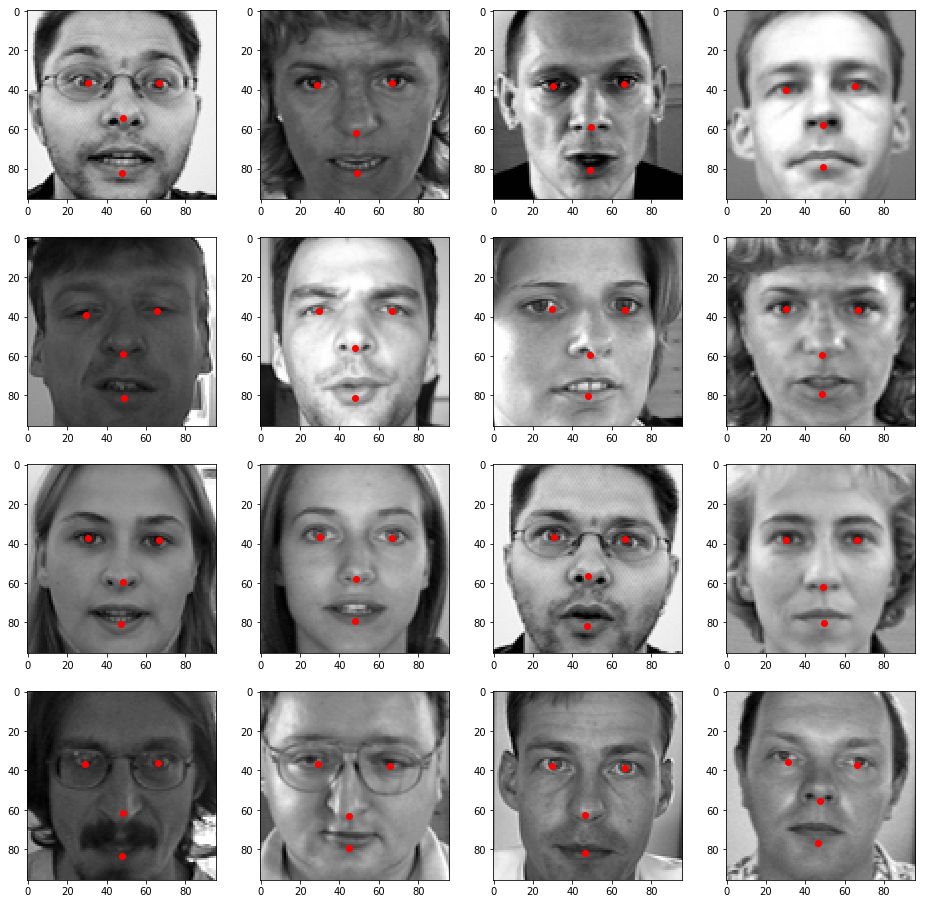

In [44]:
f, ax = plt.subplots(4, 4, figsize=(16, 16))
for i in range(4):
    for j in range(4):
        for k in range(4):
            ax[i, j].plot(cnn_pred_df.iloc[i*4 + j, 2*k], cnn_pred_df.iloc[i*4 + j, 2*k+1], c='r', marker='o')
        ax[i, j].imshow(X_test[i*4 + j].reshape(96, 96), cmap='gray')

In [18]:
a = four_keypoints[four_keypoints['nose_tip_y'] == max(four_keypoints['nose_tip_y'])]

In [19]:
a

,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,Image
4436,58.940509,88.825658,58.811171,93.084567,68.710953,74.29536,46.414429,74.796393,171 173 173 175 175 176 176 177 178 178 180 18...


In [20]:
b = np.fromstring(a.Image.values[0], sep=' ')
b = np.vstack(b)/255

In [21]:
c = b.reshape(-1, 96, 96, 1)

In [22]:
single_pred = cnn.predict(c)*48 +48
single_pred = pd.DataFrame(single_pred, columns=four_keypoints.drop('Image', axis=1).columns)

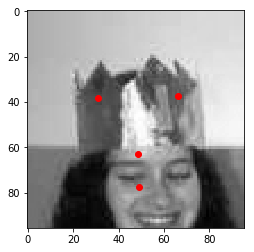

In [24]:
for k in range(4):
    plt.plot(single_pred.iloc[0, 2*k], single_pred.iloc[0, 2*k+1], c='r', marker='o')
plt.imshow(b.reshape(96, 96), cmap='gray')

In [15]:
from keras.models import load_model

In [25]:
cnn1 = load_model('cnn1.h5')

In [26]:
y_train_pred_cnn = cnn1.predict(X2)

In [27]:
y_train_pred_cnn = y_train_pred_cnn*48 + 48

In [28]:
cnn_train_pred_df = pd.DataFrame(y_train_pred_cnn, columns=four_keypoints.drop('Image', axis=1).columns)

In [29]:
from random import randint

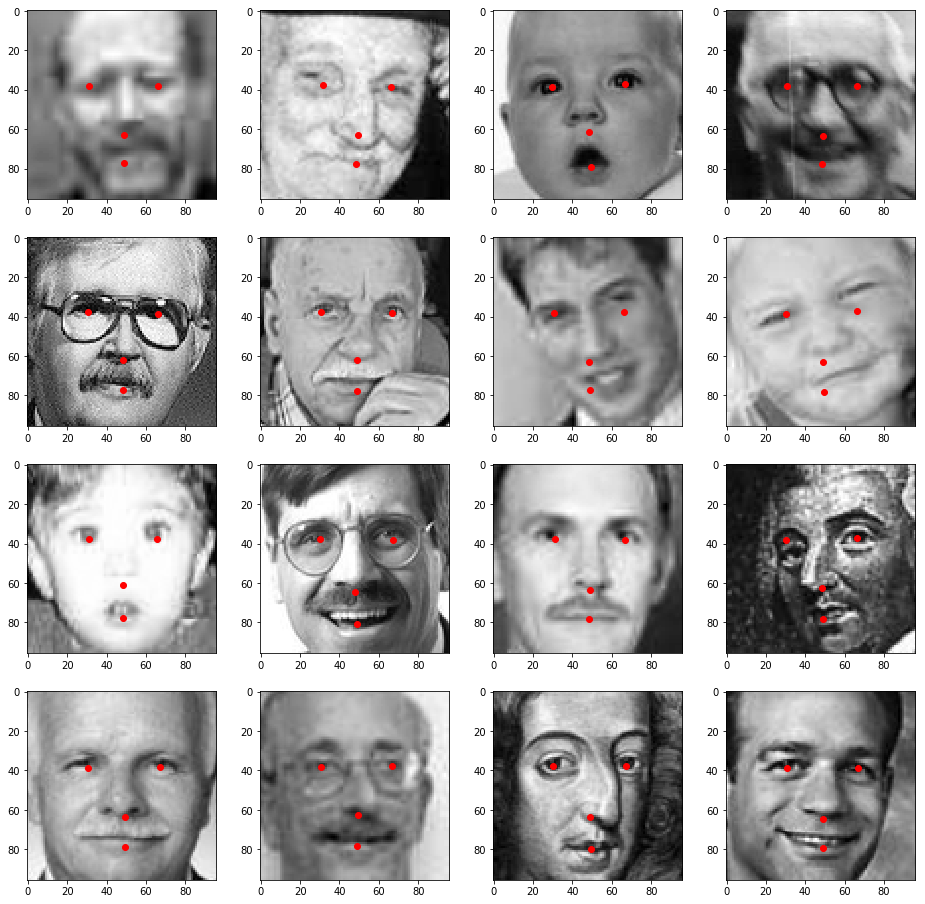

In [31]:
rndm = randint(0, 6980)
f, ax = plt.subplots(4, 4, figsize=(16, 16))
for i in range(4):
    for j in range(4):
        for k in range(4):
            ax[i, j].plot(cnn_train_pred_df.iloc[i*4 + j + rndm, 2*k], cnn_train_pred_df.iloc[i*4 + j + rndm, 2*k+1], c='r', marker='o')
        ax[i, j].imshow(X[i*4 + j + rndm].reshape(96, 96), cmap='gray')